In [1]:
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

In [2]:
# combine result dataframes
results = pd.DataFrame()
for file in ['pre_pandemic_regression_results.csv',
             'post_pandemic_regression_results.csv',
             'pre_pandemic_ensemble_results.csv',
             'post_pandemic_ensemble_results.csv']:
    sp = file.split('_')
    segment = sp[0]
    model = sp[2]
    df = pd.read_csv(file)
    df['model'] = model
    df['segment'] = segment
    results = pd.concat([results, df])
results.sort_values('rmse')
results['feature_list'] = results.features.apply(lambda x: sorted(x.split(',')))
print(results.shape)
results.head()

(65536, 9)


,train_observations,test_observations,features,mse,rmse,model,segment,score,feature_list
0,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76804.840422,277.136862,regression,pre,NaN,"[calendar_day, calendar_month, calendar_weekda..."
1,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76903.893160,277.315512,regression,pre,NaN,"[calendar_day, calendar_month, calendar_weekda..."
2,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76979.989547,277.452680,regression,pre,NaN,"[calendar_day, calendar_month, calendar_weekda..."
3,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76993.703855,277.477393,regression,pre,NaN,"[calendar_day, calendar_month, calendar_weekda..."
4,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",77018.079401,277.521313,regression,pre,NaN,"[calendar_day, calendar_month, calendar_weekda..."


In [20]:
results.drop('score', axis=1, inplace=True)

In [22]:
results.query('segment == "pre"').describe()

,train_observations,test_observations,mse,rmse
count,32768.000000,32768.000000,3.276800e+04,32768.000000
mean,954.163818,239.290161,8.642771e+05,608.508355
std,57.643559,14.407238,4.584475e+06,702.858256
min,933.000000,234.000000,7.680484e+04,277.136862
25%,933.000000,234.000000,1.228590e+05,350.512450
50%,933.000000,234.000000,1.823356e+05,427.007691
75%,933.000000,234.000000,3.218285e+05,567.299312
max,1224.000000,307.000000,1.834092e+08,13542.865455


In [23]:
results.query('segment == "post"').describe()

,train_observations,test_observations,mse,rmse
count,32768.0,32768.0,3.276800e+04,32768.000000
mean,1113.0,279.0,1.007927e+07,1894.556096
std,0.0,0.0,4.248743e+07,2547.573178
min,1113.0,279.0,4.438893e+05,666.250185
25%,1113.0,279.0,7.047643e+05,839.502422
50%,1113.0,279.0,1.304362e+06,1142.086666
75%,1113.0,279.0,2.554854e+06,1598.391141
max,1113.0,279.0,1.169634e+09,34199.909880


/tmp/ipykernel_214251/81279543.py:3: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=5.0)


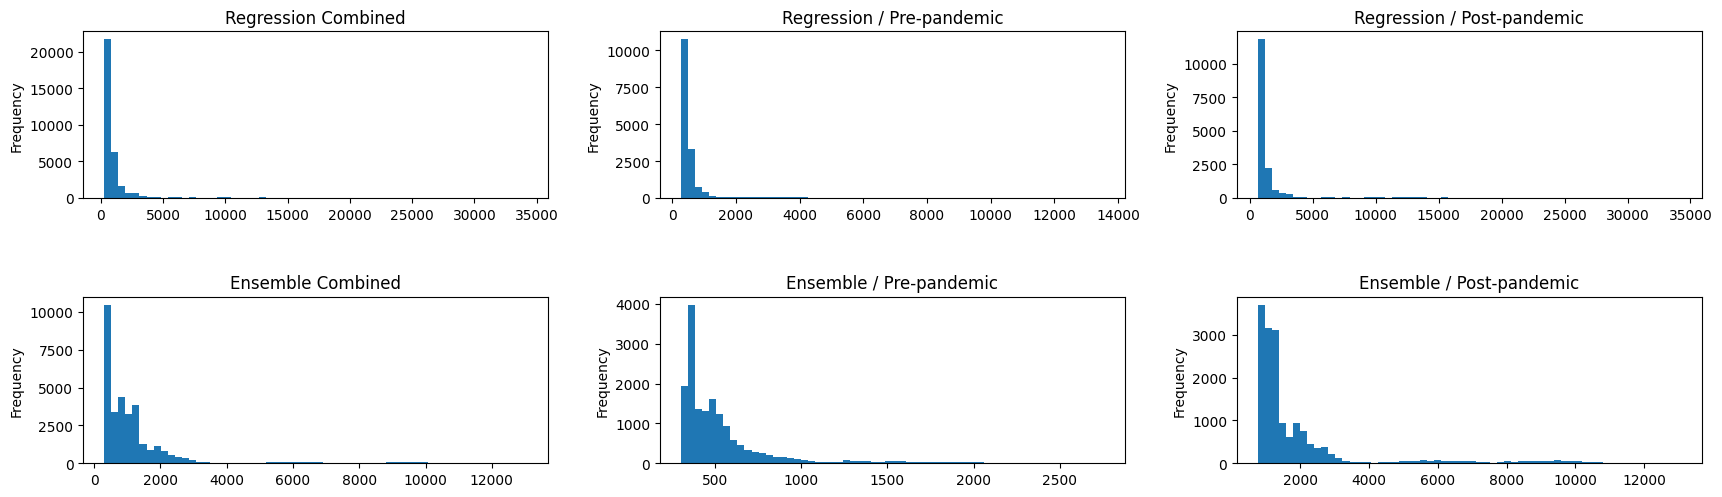

In [16]:
# visualize distribution of values
fig, ax = plt.subplots(2, 3, figsize=(18, 6), constrained_layout=True)
fig.tight_layout(pad=5.0)
results.query('model == "regression"').rmse.plot.hist(bins=60, ax=ax[0][0])
ax[0][0].title.set_text('Regression Combined')
results.query('model == "regression" and segment == "pre"').rmse.plot.hist(bins=60, ax=ax[0][1])
ax[0][1].title.set_text('Regression / Pre-pandemic')
results.query('model == "regression" and segment == "post"').rmse.plot.hist(bins=60, ax=ax[0][2])
ax[0][2].title.set_text('Regression / Post-pandemic')
results.query('model == "ensemble"').rmse.plot.hist(bins=60, ax=ax[1][0])
ax[1][0].title.set_text('Ensemble Combined')
results.query('model == "ensemble" and segment == "pre"').rmse.plot.hist(bins=60, ax=ax[1][1])
ax[1][1].title.set_text('Ensemble / Pre-pandemic')
results.query('model == "ensemble" and segment == "post"').rmse.plot.hist(bins=60, ax=ax[1][2])
ax[1][2].title.set_text('Ensemble / Post-pandemic')

### Findings

Strong skewness in all distributions; right tailed.

In [24]:
# create a list of all our features
features = results.features.unique()
unique_features = []
for f in features:
    f_sp = f.split(',')
    unique_features.extend(f_sp)
unique_features = set(unique_features)

In [25]:
# we want to apply the Wilcoxon Signed-Rank Test
# we want to apply the test for each individual nbdi-derived feature
# we can also apply for any nbdi-derived feature
# we also want to apply for each segment

def create_pairs(target, features, temporal_features):
    n = len(features)
    combos = []
    pairs = []
    for i in range(1, n + 1):
        combos.extend(list(combinations(features, i)))
    if type(target) == list:
        for c in combos:
            pairs.append((sorted([*c, *temporal_features]), sorted([*target, *c, *temporal_features])))
    else:
        for c in combos:
            pairs.append((sorted([*c, *temporal_features]), sorted([target, *c, *temporal_features])))
    return pairs


def rmse_differences(df, pairs):
    d = []
    for wo, w in pairs:
        # should be multiple rows for each feature set
        w_rows = df[df.feature_list.apply(lambda x: x == w)].rmse.values
        wo_rows = df[df.feature_list.apply(lambda x: x == wo)].rmse.values
        d.extend(w_rows - wo_rows)
    return d


def separate_distributions(df, pairs):
    w_values = []
    wo_values = []
    for wo, w in pairs:
        w_values.extend(df[df.feature_list.apply(lambda x: x == w)].rmse.values)
        wo_values.extend(df[df.feature_list.apply(lambda x: x == wo)].rmse.values)
    return np.array(wo_values), np.array(w_values)


def do_wilcoxon(differences):
    return wilcoxon(differences)

def do_cohens_d(d1, d2):
    mean_diff = d1.mean() - d2.mean()
    pooled_std = ((len(d1) - 1) * d1.std()**2 + (len(d2) - 1) * d2.std()**2) / (len(d1) + len(d2) - 2)
    d = mean_diff / (pooled_std**0.5)
    return d

In [58]:
# test each nbdi-related feature in isolation
temporal_features = [f for f in unique_features if 'calendar' in f or 'elapsed' in f or f == 'post_pandemic']
other_features = [f for f in unique_features if 'nbdi' not in f and f not in temporal_features]
nbdi_features = [f for f in unique_features if 'nbdi' in f]

res = []

for nbdi_feature in nbdi_features:
    pairs = create_pairs(nbdi_feature, other_features, temporal_features)
    pre_wo, pre_w = separate_distributions(results[results.segment == 'pre'], pairs)
    post_wo, post_w = separate_distributions(results[results.segment == 'post'], pairs)
    pre_differences = rmse_differences(results[results.segment == 'pre'], pairs)
    post_differences = rmse_differences(results[results.segment == 'post'], pairs)
    pre_wilcoxon = do_wilcoxon(pre_differences)
    post_wilcoxon = do_wilcoxon(post_differences)
    pre_cohens = do_cohens_d(pre_wo, pre_w)
    post_cohens = do_cohens_d(post_wo, post_w)

    res.append({
        'feature': nbdi_feature,
        'n_pairs': len(pairs),
        'n_pre_observations': len(pre_wo),
        'n_post_observations': len(post_wo),
        'pre_difference_mean': np.mean(pre_differences),
        'post_difference_mean': np.mean(post_differences),
        'pre_wilcoxon': pre_wilcoxon.pvalue,
        'post_wilcoxon': post_wilcoxon.pvalue,
        'pre_cohens': pre_cohens,
        'post_cohens': post_cohens
    })
    
nbdi_significance = pd.DataFrame.from_dict(res)

In [59]:
# test with all nbdi features
temporal_features = [f for f in unique_features if 'calendar' in f or 'elapsed' in f or f == 'post_pandemic']
other_features = [f for f in unique_features if 'nbdi' not in f and f not in temporal_features]
nbdi_features = [f for f in unique_features if 'nbdi' in f]

res = []

pairs = create_pairs(nbdi_features, other_features, temporal_features)
pre_wo, pre_w = separate_distributions(results[results.segment == 'pre'], pairs)
post_wo, post_w = separate_distributions(results[results.segment == 'post'], pairs)
pre_differences = rmse_differences(results[results.segment == 'pre'], pairs)
post_differences = rmse_differences(results[results.segment == 'post'], pairs)
pre_wilcoxon = do_wilcoxon(pre_differences)
post_wilcoxon = do_wilcoxon(post_differences)
pre_cohens = do_cohens_d(pre_wo, pre_w)
post_cohens = do_cohens_d(post_wo, post_w)

res.append({
    'feature': 'all',
    'n_pairs': len(pairs),
    'n_pre_observations': len(pre_wo),
    'n_post_observations': len(post_wo),
    'pre_difference_mean': np.mean(pre_differences),
    'post_difference_mean': np.mean(post_differences),
    'pre_wilcoxon': pre_wilcoxon.pvalue,
    'post_wilcoxon': post_wilcoxon.pvalue,
    'pre_cohens': pre_cohens,
    'post_cohens': post_cohens
})

all_nbdi_significance = pd.DataFrame.from_dict(res)

In [60]:
def create_sort_keys(x):
    if x == 'all':
        return 0
    sp = x.split('_')
    if len(sp) > 1:
        return int(sp[2])
    return 1
    
nbdi_significance = pd.concat([nbdi_significance, all_nbdi_significance], ignore_index=True)
nbdi_significance['key'] = nbdi_significance.feature.apply(create_sort_keys)
nbdi_significance.sort_values('key', ascending=True, inplace=True, ignore_index=True)
nbdi_significance.to_csv('nbdi_results.csv')

In [61]:
ns = nbdi_significance[['feature', 'pre_difference_mean', 'post_difference_mean', 'pre_wilcoxon', 'post_wilcoxon', 'pre_cohens', 'post_cohens']]
ns

,feature,pre_difference_mean,post_difference_mean,pre_wilcoxon,post_wilcoxon,pre_cohens,post_cohens
0,all,49.031538,404.094509,0.000600,5.273706e-126,-0.083114,-0.146390
1,nbdi,-7.830262,-87.657705,0.084431,2.000915e-01,0.019434,0.032330
2,nbdi_ma_30,1.198069,-137.219316,0.904577,1.539247e-01,-0.002856,0.052583
3,nbdi_ma_90,23.485908,-188.249709,0.024437,1.822923e-07,-0.052312,0.076042
4,nbdi_ma_180,43.481900,162.957758,0.101219,2.102142e-127,-0.080543,-0.065406
5,nbdi_ma_365,66.524819,522.860729,0.240027,1.648925e-16,-0.115498,-0.126897


Text(0, 0.5, 'Practical Significance')

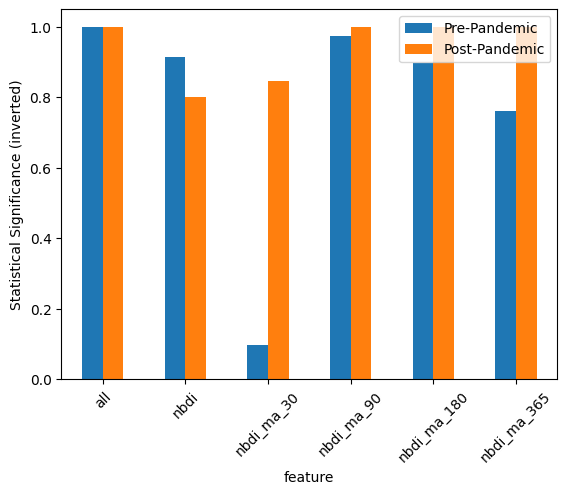

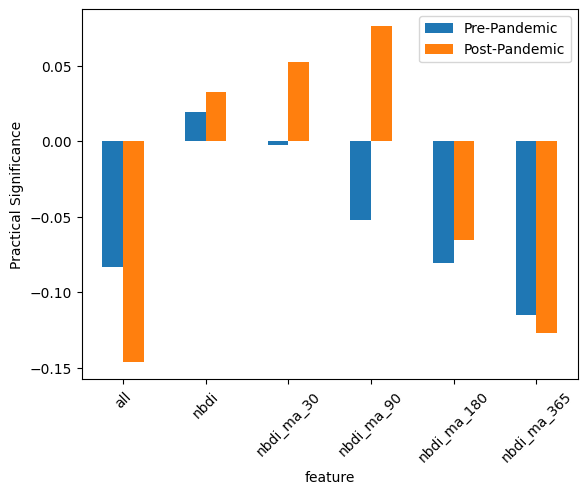

In [79]:
# make a friendly bar chart with statistical and practical significance
ss = ns.copy()[['feature', 'pre_wilcoxon', 'post_wilcoxon']]
ss = ss.set_index('feature', drop=True)
ss['Pre-Pandemic'] = 1 - ss.pre_wilcoxon
ss['Post-Pandemic'] = 1 - ss.post_wilcoxon
ss.drop(['pre_wilcoxon', 'post_wilcoxon'], axis=1).plot(kind='bar')
plt.gca().xaxis.set_tick_params(rotation=45)
plt.ylabel('Statistical Significance (inverted)')

ps = ns.copy()[['feature', 'pre_cohens', 'post_cohens']]
ps = ps.set_index('feature', drop=True)
ps['Pre-Pandemic'] = ps.pre_cohens
ps['Post-Pandemic'] = ps.post_cohens
ps.drop(['pre_cohens', 'post_cohens'], axis=1).plot(kind='bar')
plt.gca().xaxis.set_tick_params(rotation=45)
plt.ylabel('Practical Significance')